In [2]:
import os, sys

import numpy as np

import torch
from torch import nn
from torchvision import transforms

import matplotlib.pyplot as plt

sys.path.append('../..')

from lib.datasets import (get_train_test_img_ids_split, get_kfolds, actual_lbl_nums,
                          patches_rgb_mean_av1, patches_rgb_std_av1)
from lib.dataloaders import PatchesDataset
from lib.augmentations import augment_empty, augment_v1
from lib.models.unetv1 import get_model

train_img_ids, test_img_ids = get_train_test_img_ids_split()

from tqdm.auto import tqdm

In [3]:
device = torch.device('cuda:1')

In [4]:
tmp = torch.load("./Patches256TestRun/version_0/checkpoints/epoch0_manual.ckpt", map_location=device)

In [5]:
model = get_model(actual_lbl_nums)

In [6]:
module = nn.Sequential()

In [7]:
module.add_module('model', model)

In [8]:
module.to(device);

In [9]:
module.load_state_dict(tmp['state_dict'])

<All keys matched successfully>

In [10]:
next(model.parameters()).device

device(type='cuda', index=1)

In [11]:
batch_size = 256
num_workers = 6

In [12]:
train_loader = torch.utils.data.DataLoader(
    PatchesDataset(train_img_ids, transform=augment_v1,
                   scale=0.5,
                   load_masks=True),
    batch_size=batch_size, shuffle=True,
    num_workers=num_workers, pin_memory=False,
)

val_loader = torch.utils.data.DataLoader(
    PatchesDataset(test_img_ids, transform=augment_empty,
                   scale=0.5,
                   load_masks=True),
    batch_size=batch_size, shuffle=False,
    num_workers=num_workers, pin_memory=False,
)

In [231]:
with torch.no_grad():
    for imgs, masks, labels, providers, isup_grades, g_scores in val_loader:
        n_imgs = (imgs - patches_rgb_mean_av1) / patches_rgb_std_av1
        
        n_imgs = n_imgs.float().to(device)
        
        o_masks, o_labels, o_imgs = model(n_imgs)
        
        break

In [232]:
decoded.shape

torch.Size([16, 3, 256, 256])

In [233]:
n = 0

In [278]:
n += 1

In [279]:
providers[n].item()

0

In [280]:
[f"{labels[n, l].item():.2f} {o_labels[n, l].exp().item():.2f}" for l in range(actual_lbl_nums)]

['0.00 0.15',
 '0.83 0.23',
 '0.00 0.15',
 '0.00 0.15',
 '0.00 0.16',
 '0.17 0.15',
 '0.00 0.00',
 '0.00 0.00',
 '0.00 0.00']

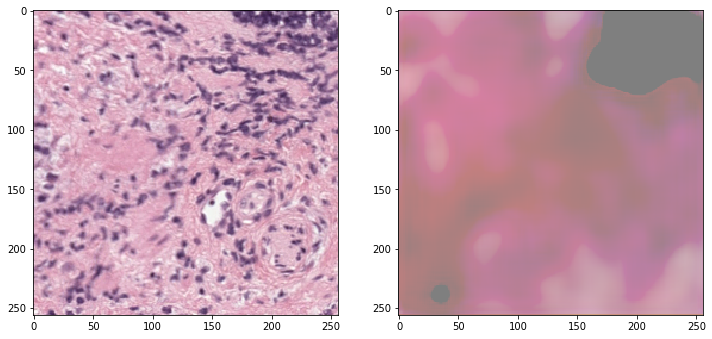

In [281]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(imgs[n].cpu().transpose(0, -1));
axs[1].imshow(o_imgs[n].cpu().transpose(0, -1));

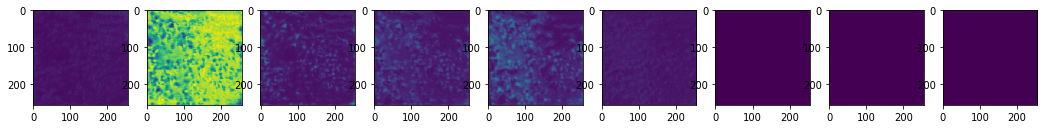

In [282]:
fig, axs = plt.subplots(1, actual_lbl_nums, figsize=(18, 18))
e_mask = o_masks[n].exp().cpu()
vmin, vmax = e_mask.min(), e_mask.max()
for m in range(actual_lbl_nums):
    axs[m].imshow(e_mask[m].T, vmin=vmin, vmax=vmax);

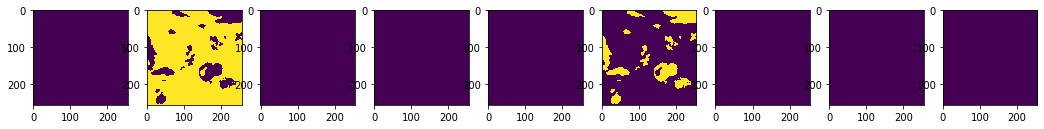

In [283]:
fig, axs = plt.subplots(1, actual_lbl_nums, figsize=(18, 18))
e_mask = masks[n].cpu()
for m in range(actual_lbl_nums):
    axs[m].imshow(e_mask.T == m, vmin=0, vmax=1);